## Emotion Detection usig Facial Images

### Loading the training, validation and test data

In [120]:
# importing necessary libraries for emotion detection
import os
import numpy as np
import cv2

In [121]:
# load the data from the folder "data" using os library
def load_data(data_path):
    data = []
    labels = []
    for folder in os.listdir(data_path):
        for file in os.listdir(os.path.join(data_path, folder)):
            # Reading the images using cv2 library
            img = cv2.imread(os.path.join(data_path, folder, file), cv2.IMREAD_GRAYSCALE)
            data.append(img)
            labels.append(folder)
            
    return data, labels

In [122]:
# Loading the train, validation and test data using the load_data function
train_data, train_labels = load_data('./data/train')
val_data, val_labels = load_data('./data/validation')
test_data, test_labels = load_data('./data/test')

In [123]:
print('Train data:', len(train_data), "images")
print('Val data:', len(val_data), "images")
print('Test data:', len(test_data), "images")

Train data: 26921 images
Val data: 7066 images
Test data: 1900 images


### One hot encoding the labels

In [124]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels = le.transform(val_labels)
test_labels = le.transform(test_labels)

train_labels = to_categorical(train_labels)
val_labels = to_categorical(val_labels)
test_labels = to_categorical(test_labels)

In [125]:
print('Train labels:', train_labels.shape)
print('Val labels:', val_labels.shape)
print('Test labels:', test_labels.shape)

Train labels: (26921, 7)
Val labels: (7066, 7)
Test labels: (1900, 7)


### Create data loaders for train, validation and test data using tensorflow library

In [126]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Reshape the data to 48x48x1
train_data = np.array(train_data).reshape(-1, 48, 48, 1)
val_data = np.array(val_data).reshape(-1, 48, 48, 1)
test_data = np.array(test_data).reshape(-1, 48, 48, 1)

# Normalize the data
train_data = train_data / 255.0
val_data = val_data / 255.0
test_data = test_data / 255.0

# Create data generators for train, validation and test data
datagen = ImageDataGenerator()

train_generator = datagen.flow(train_data, train_labels, batch_size=32)
val_generator = datagen.flow(val_data, val_labels, batch_size=32)
test_generator = datagen.flow(test_data, test_labels, batch_size=32)

In [127]:
print('Train data:', train_data.shape)
print('Val data:', val_data.shape)
print('Test data:', test_data.shape)

Train data: (26921, 48, 48, 1)
Val data: (7066, 48, 48, 1)
Test data: (1900, 48, 48, 1)


### Create a CNN model

In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

model = Sequential([
    
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

/home/amit/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [129]:
# Setting the learning rate and optimizer
init_lr = 1e-3
lr_schedule = ExponentialDecay(initial_learning_rate=init_lr, decay_steps=100000, decay_rate=0.96)

optimizer = Adam(learning_rate=lr_schedule)

In [130]:
# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

In [131]:
history = model.fit(train_generator, steps_per_epoch=26921 // 32, epochs=30, validation_data=val_generator, validation_steps=7066 // 32)

Epoch 1/30


/home/amit/.pyenv/versions/3.10.14/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


841/841 ━━━━━━━━━━━━━━━━━━━━ 117s 136ms/step - accuracy: 0.2564 - loss: 1.7945 - val_accuracy: 0.4085 - val_loss: 1.5498
Epoch 2/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 147us/step - accuracy: 0.4688 - loss: 1.4980 - val_accuracy: 0.3846 - val_loss: 1.6931
Epoch 3/30


2024-06-12 19:29:35.816308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/amit/.pyenv/versions/3.10.14/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-06-12 19:29:35.908061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 116s 138ms/step - accuracy: 0.4198 - loss: 1.4882 - val_accuracy: 0.4974 - val_loss: 1.3338
Epoch 4/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.4688 - loss: 1.1512 - val_accuracy: 0.5000 - val_loss: 1.1503
Epoch 5/30


2024-06-12 19:31:32.232007: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:31:32.268123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 116s 138ms/step - accuracy: 0.4961 - loss: 1.3148 - val_accuracy: 0.5362 - val_loss: 1.2379
Epoch 6/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - accuracy: 0.6562 - loss: 0.9698 - val_accuracy: 0.3846 - val_loss: 1.3243
Epoch 7/30


2024-06-12 19:33:28.869479: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:33:28.903358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 116s 138ms/step - accuracy: 0.5405 - loss: 1.2158 - val_accuracy: 0.5520 - val_loss: 1.1881
Epoch 8/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.4375 - loss: 1.4950 - val_accuracy: 0.5385 - val_loss: 1.1432
Epoch 9/30


2024-06-12 19:35:25.411867: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:35:25.446184: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 116s 138ms/step - accuracy: 0.5524 - loss: 1.1734 - val_accuracy: 0.5706 - val_loss: 1.1402
Epoch 10/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 59us/step - accuracy: 0.5312 - loss: 1.2889 - val_accuracy: 0.6538 - val_loss: 0.8664
Epoch 11/30


2024-06-12 19:37:21.993116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:37:22.025133: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 118s 140ms/step - accuracy: 0.5748 - loss: 1.1221 - val_accuracy: 0.5813 - val_loss: 1.1264
Epoch 12/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - accuracy: 0.6562 - loss: 1.0553 - val_accuracy: 0.6154 - val_loss: 1.0109
Epoch 13/30


2024-06-12 19:39:20.069660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:39:20.110608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 119s 141ms/step - accuracy: 0.5847 - loss: 1.0806 - val_accuracy: 0.5845 - val_loss: 1.1079
Epoch 14/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.5938 - loss: 0.9979 - val_accuracy: 0.5385 - val_loss: 1.1364
Epoch 15/30


2024-06-12 19:41:19.107202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:41:19.140449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 119s 141ms/step - accuracy: 0.6055 - loss: 1.0345 - val_accuracy: 0.5737 - val_loss: 1.1319
Epoch 16/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.5938 - loss: 1.0350 - val_accuracy: 0.5385 - val_loss: 1.1794
Epoch 17/30


2024-06-12 19:43:18.316219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:43:18.353631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 120s 143ms/step - accuracy: 0.6235 - loss: 0.9936 - val_accuracy: 0.5969 - val_loss: 1.0997
Epoch 18/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.6875 - loss: 0.9736 - val_accuracy: 0.5769 - val_loss: 1.2457
Epoch 19/30


2024-06-12 19:45:18.658817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:45:18.694704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 120s 143ms/step - accuracy: 0.6454 - loss: 0.9482 - val_accuracy: 0.5979 - val_loss: 1.0850
Epoch 20/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 70us/step - accuracy: 0.6250 - loss: 0.9407 - val_accuracy: 0.7308 - val_loss: 0.8446
Epoch 21/30


2024-06-12 19:47:19.150781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:47:19.187884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 120s 142ms/step - accuracy: 0.6472 - loss: 0.9345 - val_accuracy: 0.5943 - val_loss: 1.0968
Epoch 22/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.6250 - loss: 1.1847 - val_accuracy: 0.4615 - val_loss: 1.6090
Epoch 23/30


2024-06-12 19:49:19.178179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:49:19.213257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 121s 144ms/step - accuracy: 0.6679 - loss: 0.8811 - val_accuracy: 0.6017 - val_loss: 1.0874
Epoch 24/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 72us/step - accuracy: 0.6562 - loss: 1.2307 - val_accuracy: 0.4231 - val_loss: 1.4056
Epoch 25/30


2024-06-12 19:51:20.455647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:51:20.494687: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 121s 143ms/step - accuracy: 0.6755 - loss: 0.8620 - val_accuracy: 0.5999 - val_loss: 1.1058
Epoch 26/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step - accuracy: 0.7188 - loss: 0.6579 - val_accuracy: 0.5000 - val_loss: 1.2371
Epoch 27/30


2024-06-12 19:53:21.231511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:53:21.282351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 121s 143ms/step - accuracy: 0.6892 - loss: 0.8292 - val_accuracy: 0.5991 - val_loss: 1.1115
Epoch 28/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 65us/step - accuracy: 0.7188 - loss: 0.7944 - val_accuracy: 0.3846 - val_loss: 1.4908
Epoch 29/30


2024-06-12 19:55:22.103440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:55:22.136669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


841/841 ━━━━━━━━━━━━━━━━━━━━ 122s 145ms/step - accuracy: 0.6976 - loss: 0.8098 - val_accuracy: 0.6101 - val_loss: 1.1063
Epoch 30/30
841/841 ━━━━━━━━━━━━━━━━━━━━ 0s 61us/step - accuracy: 0.7500 - loss: 0.5529 - val_accuracy: 0.6538 - val_loss: 1.1935


2024-06-12 19:57:23.916154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-12 19:57:23.949337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [132]:
# Evaluate the model
model.evaluate(test_generator, steps=7066 // 32)

220/220 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5561 - loss: 1.2573


2024-06-12 20:56:49.068274: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


[1.2618385553359985, 0.5542105436325073]

In [133]:
# Calculate accuracy and loss
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

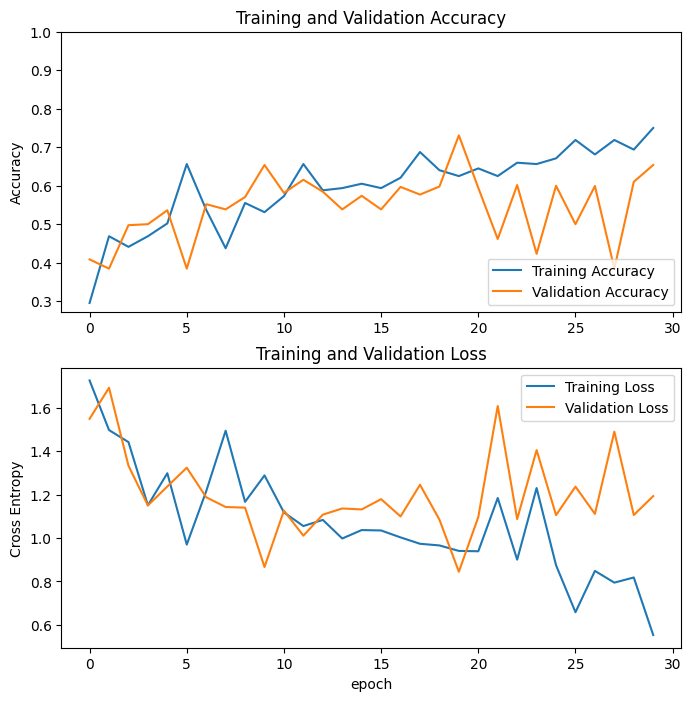

In [134]:
# Plot the accuracy and loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [135]:
# Save the model architecture
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model.to_json())

In [138]:
# Save the model weights
model.save_weights('emotion_detection.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


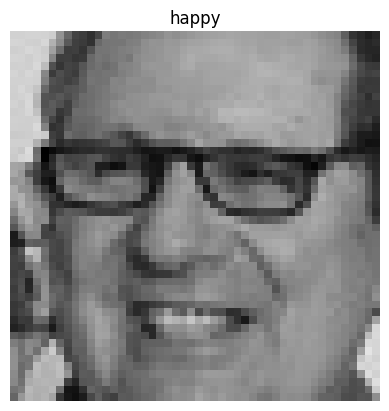

In [140]:
# Load the model weights and predict the emotion
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np

# Load the model architecture
with open('model_architecture.json', 'r') as json_file:
    model_json = json_file.read()

model = model_from_json(model_json)

# Load the model weights
model.load_weights('emotion_detection.weights.h5')

# Plot the image with the predicted emotion
def predict_emotion(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    result = model.predict(img)
    result = np.argmax(result)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(le.inverse_transform([result])[0])
    plt.show()

# Predict the emotion for the test image
predict_emotion('./data/test/happy/28.jpg')